In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from wordcloud import STOPWORDS
import nltk
import string
nltk.download('punkt')
nltk.download('stopwords')
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report,mean_squared_error
%matplotlib inline

import warnings
warnings.filterwarnings('ignore')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Lenovo\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('drugsComTrain_raw.csv')
data

,uniqueID,drugName,condition,review,rating,date,usefulCount
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
...,...,...,...,...,...,...,...
161292,191035,Campral,Alcohol Dependence,"""I wrote my first report in Mid-October of 201...",10,31-May-15,125
161293,127085,Metoclopramide,Nausea/Vomiting,"""I was given this in IV before surgey. I immed...",1,1-Nov-11,34
161294,187382,Orencia,Rheumatoid Arthritis,"""Limited improvement after 4 months, developed...",2,15-Mar-14,35
161295,47128,Thyroid desiccated,Underactive Thyroid,"""I&#039;ve been on thyroid medication 49 years...",10,19-Sep-15,79


In [3]:
# Define the conditions to keep
#keep_conditions = ["Depression", "High Blood Pressure", "Diabetes, Type 2"]
keep_conditions = ['Birth Control','Depression','Pain','Anxiety''Acne','Bipolar Disorde','Insomnia','Weight Loss','Obesity','ADHD']

# Filter the DataFrame to only keep the records with the specified conditions
df = data[data['condition'].isin(keep_conditions)]

df.drop(['uniqueID'],axis =1,inplace=True)

df.head()

,drugName,condition,review,rating,date,usefulCount
1,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
7,Aripiprazole,Bipolar Disorde,"""Abilify changed my life. There is hope. I was...",10,14-Mar-15,32
9,Ethinyl estradiol / levonorgestrel,Birth Control,"""I had been on the pill for many years. When m...",8,8-Dec-16,1


In [4]:
df['drugName'].value_counts().nlargest(20)

Etonogestrel                          3314
Ethinyl estradiol / norethindrone     2337
Nexplanon                             2149
Levonorgestrel                        2129
Ethinyl estradiol / levonorgestrel    1600
Ethinyl estradiol / norgestimate      1580
Phentermine                           1515
Implanon                              1095
Mirena                                 965
Bupropion / naltrexone                 945
Contrave                               912
Skyla                                  822
Lo Loestrin Fe                         667
Bupropion                              644
Ethinyl estradiol / etonogestrel       631
NuvaRing                               620
Copper                                 607
Lorcaserin                             572
Quetiapine                             572
Belviq                                 562
Name: drugName, dtype: int64

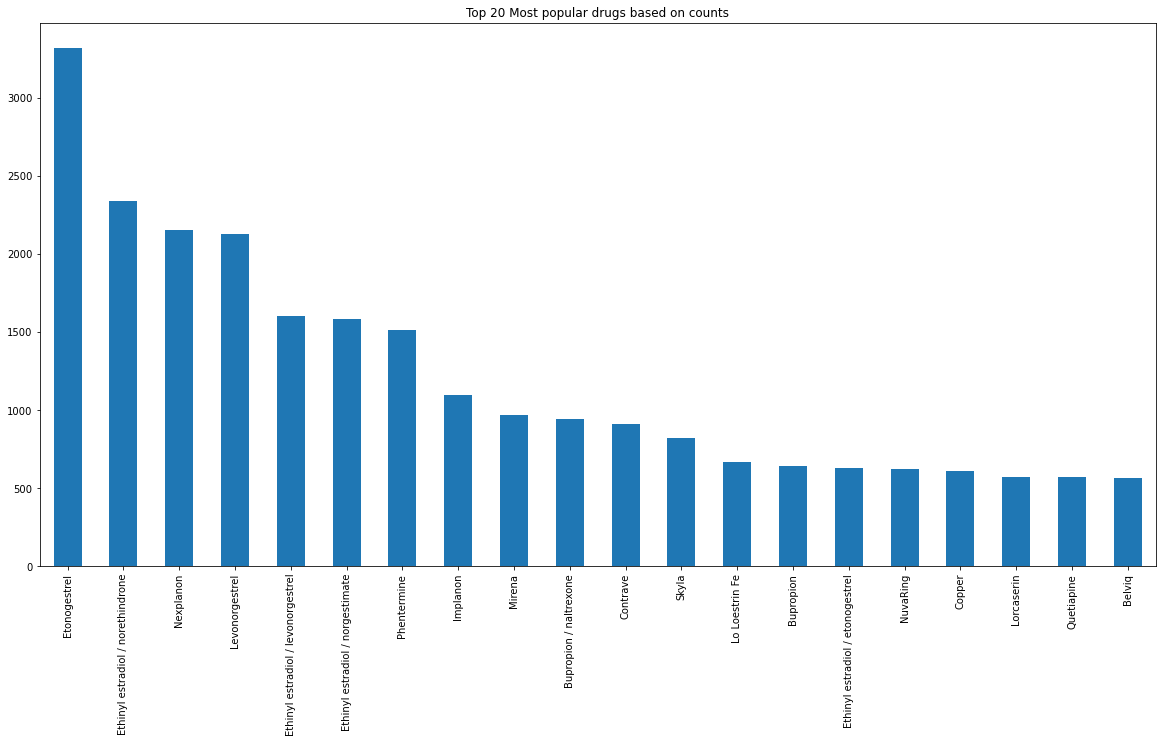

In [5]:
# Top 20 Drugs(MOst Popular)
plt.figure(figsize=(20,10))
df['drugName'].value_counts().nlargest(20).plot(kind='bar')
plt.title('Top 20 Most popular drugs based on counts')
plt.show()

<Figure size 1080x720 with 0 Axes>

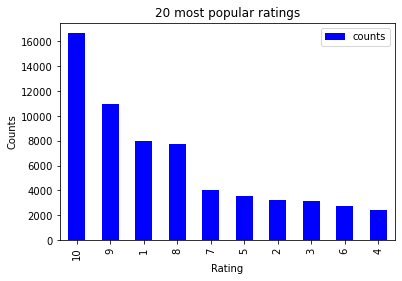

In [6]:
rating_counts = df.groupby('rating').size().reset_index(name='counts')

# Sort the data by the frequency of each rating
rating_counts = rating_counts.sort_values(by='counts',ascending=False)

# Plot a bar chart of the 20 most popular ratings
plt.figure(figsize=(15,10))
rating_counts[:20].plot.bar(x='rating',y='counts',color='blue')
plt.xlabel('Rating')
plt.ylabel('Counts')
plt.title('20 most popular ratings')
plt.show()

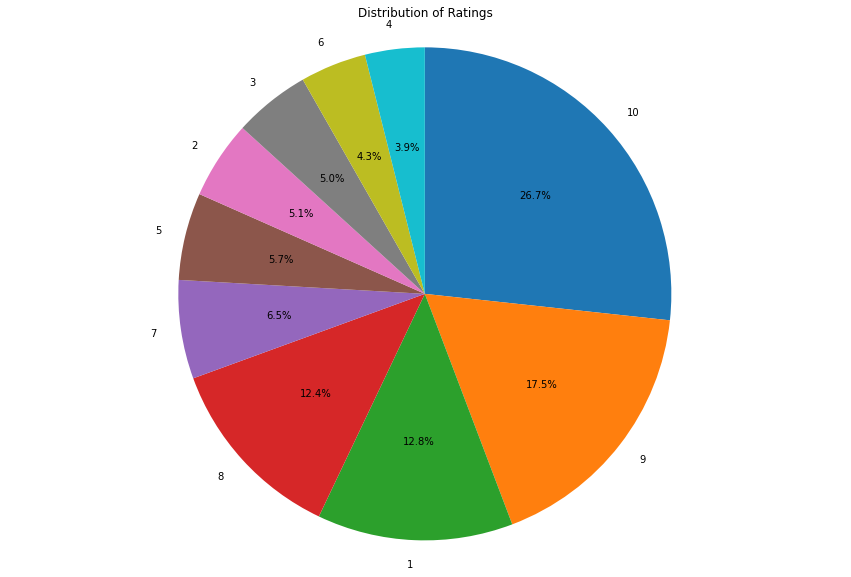

In [7]:
plt.figure(figsize=(15,10))
plt.pie(rating_counts['counts'], labels=rating_counts['rating'], startangle=90, counterclock=False, autopct='%1.1f%%')
plt.axis('equal')
plt.title('Distribution of Ratings')
plt.show()

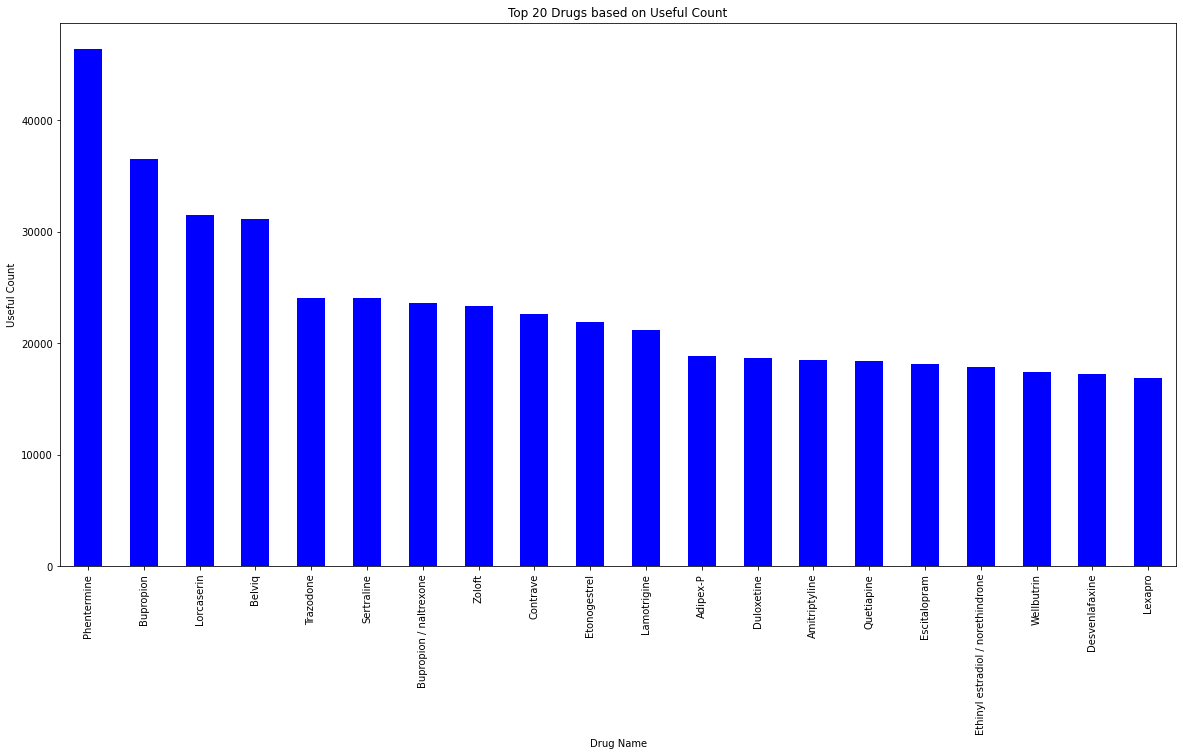

In [8]:
plt.figure(figsize=(20,10))
top_20_drugs = df.groupby('drugName')['usefulCount'].sum().sort_values(ascending=False).head(20)

# Plot the bar plot
top_20_drugs.plot(kind='bar', color='blue')
plt.xlabel('Drug Name')
plt.ylabel('Useful Count')
plt.title('Top 20 Drugs based on Useful Count')
plt.xticks(rotation=90)
plt.show()

In [9]:
def clean_review(review):
    # Convert to lowercase
    review = review.lower()
    
    # Remove punctuation
    review = review.translate(str.maketrans('', '', string.punctuation))
    
    # Tokenize the review
    tokens = nltk.word_tokenize(review)
    
    # Remove stop words
    tokens = [word for word in tokens if word not in stopwords.words('english')]
    
    # Join the cleaned tokens back together
    cleaned_review = ' '.join(tokens)
    
    return cleaned_review

In [10]:
from nltk.corpus import stopwords
stop_words = set(stopwords.words('english'))

In [11]:
df['review'] = df['review'].apply(lambda x: clean_review(x))

In [12]:
df.drop(['date'],axis=1,inplace=True)

In [13]:
df

,drugName,condition,review,rating,usefulCount
1,Guanfacine,ADHD,son halfway fourth week intuniv became concern...,8,192
2,Lybrel,Birth Control,used take another oral contraceptive 21 pill c...,5,17
3,Ortho Evra,Birth Control,first time using form birth control i039m glad...,8,10
7,Aripiprazole,Bipolar Disorde,abilify changed life hope zoloft clonidine fir...,10,32
9,Ethinyl estradiol / levonorgestrel,Birth Control,pill many years doctor changed rx chateal effe...,8,1
...,...,...,...,...,...
161273,Nexplanon,Birth Control,nexplanon since dec 27 2016 got first period e...,6,0
161277,Zolpidem,Insomnia,started taking medication 10 years ago doctor ...,10,103
161283,Geodon,Bipolar Disorde,bad place time started taking doctor wanted we...,3,5
161286,Vortioxetine,Depression,third med i039ve tried anxiety mild depression...,2,33


In [14]:
df["rating"] = df["rating"].astype(int)

In [15]:
vectorizer = TfidfVectorizer(lowercase=True, stop_words="english")
reviews = vectorizer.fit_transform(df["review"])

In [16]:
X_train, X_test, y_train, y_test = train_test_split(reviews, df["condition"], test_size=0.25, random_state=42)

In [17]:
from sklearn.svm import SVC
model3 = SVC()
model3.fit(X_train, y_train)
y_pred = model3.predict(X_test)
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

           ADHD       0.98      0.85      0.91       881
Bipolar Disorde       0.91      0.79      0.85      1049
  Birth Control       0.99      0.99      0.99      7137
     Depression       0.83      0.93      0.88      2294
       Insomnia       0.89      0.87      0.88       919
        Obesity       0.83      0.74      0.78       878
           Pain       0.94      0.95      0.95      1591
    Weight Loss       0.79      0.82      0.80       866

       accuracy                           0.93     15615
      macro avg       0.89      0.87      0.88     15615
   weighted avg       0.93      0.93      0.93     15615



In [19]:
from sklearn.ensemble import RandomForestClassifier
model2 = RandomForestClassifier()
model2.fit(X_train, y_train)
y_pred = model2.predict(X_test)
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

           ADHD       0.98      0.84      0.90       881
Bipolar Disorde       0.94      0.75      0.83      1049
  Birth Control       0.95      1.00      0.97      7137
     Depression       0.85      0.89      0.87      2294
       Insomnia       0.87      0.87      0.87       919
        Obesity       0.84      0.69      0.75       878
           Pain       0.93      0.94      0.94      1591
    Weight Loss       0.79      0.77      0.78       866

       accuracy                           0.91     15615
      macro avg       0.89      0.84      0.86     15615
   weighted avg       0.91      0.91      0.91     15615



In [20]:
from sklearn.ensemble import GradientBoostingClassifier
model4 = GradientBoostingClassifier()
model4.fit(X_train, y_train)
y_pred = model4.predict(X_test)
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

           ADHD       0.96      0.81      0.88       881
Bipolar Disorde       0.87      0.65      0.75      1049
  Birth Control       0.92      0.98      0.95      7137
     Depression       0.77      0.83      0.80      2294
       Insomnia       0.83      0.81      0.82       919
        Obesity       0.69      0.63      0.65       878
           Pain       0.89      0.88      0.88      1591
    Weight Loss       0.73      0.60      0.65       866

       accuracy                           0.87     15615
      macro avg       0.83      0.77      0.80     15615
   weighted avg       0.86      0.87      0.86     15615



In [21]:
from sklearn.tree import DecisionTreeClassifier
model5 = DecisionTreeClassifier()
model5.fit(X_train, y_train)
y_pred = model5.predict(X_test)
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

           ADHD       0.89      0.83      0.86       881
Bipolar Disorde       0.78      0.75      0.77      1049
  Birth Control       0.96      0.97      0.96      7137
     Depression       0.80      0.82      0.81      2294
       Insomnia       0.79      0.79      0.79       919
        Obesity       0.72      0.72      0.72       878
           Pain       0.88      0.88      0.88      1591
    Weight Loss       0.73      0.72      0.72       866

       accuracy                           0.88     15615
      macro avg       0.82      0.81      0.81     15615
   weighted avg       0.88      0.88      0.88     15615



In [18]:
from sklearn.linear_model import LogisticRegression
model = LogisticRegression(multi_class="ovr")
model.fit(X_train, y_train)
y_pred = model.predict(X_test)
print(classification_report(y_test, y_pred))

                 precision    recall  f1-score   support

           ADHD       0.97      0.83      0.90       881
Bipolar Disorde       0.87      0.72      0.79      1049
  Birth Control       0.97      0.99      0.98      7137
     Depression       0.81      0.90      0.86      2294
       Insomnia       0.88      0.84      0.86       919
        Obesity       0.74      0.66      0.70       878
           Pain       0.91      0.95      0.93      1591
    Weight Loss       0.72      0.72      0.72       866

       accuracy                           0.90     15615
      macro avg       0.86      0.83      0.84     15615
   weighted avg       0.90      0.90      0.90     15615

